# Introduction

Created on Tue Jun 25 11:31:21 2019


---



This notebook demonstrates the cleaning and preparing of experimental data
for use in machine learning models. The data consists of optical, electrical,
and gravimetric/viscoelastic properties of polymer mixture PEDOT:PSS thin
films.

All experimental data is referenced to the relative humidity (RH) at which
the measurement was performed. Here we explore correlations between changing
material properties and the ambient environment.

Questions can be directed at Eric Muckley (ericmuckley@gmail.com).


# Preparing experimental data

### Import relevant modules

In [140]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.interpolate import splrep
from scipy.interpolate import splev

# this import is necessary when running the notebook in Google Colab cloud
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Define some functions which will be useful for data plotting and formatting

In [0]:
def plot_setup(labels=['X', 'Y'], size=16, setlimits=False, limits=[0,1,0,1]):
    # This function can be used with Matplotlib for setting axes labels,
    # setting axes ranges, and setting the font size of plot labels
    plt.rcParams['xtick.labelsize'] = size 
    plt.rcParams['ytick.labelsize'] = size
    plt.rcParams.update({'figure.autolayout': True})
    plt.xlabel(str(labels[0]), fontsize=size)
    plt.ylabel(str(labels[1]), fontsize=size)
    if setlimits:
        plt.xlim((limits[0], limits[1]))
        plt.ylim((limits[2], limits[3]))

def arr_stretch(arr, new_len=100, new_xlims=None, vec_scale='lin', k=3, s=0):
    # Stretches or compresses an n-D array by using a spline fit.
    # Array should be shape [[x1, y1, ...ym], ...[xn, yn, ...yn]] where the
    # first column in array is x-values, next columns are y values.
    # If no x values exist, insert column np.arange(len(arr)) as x values.
    # Accepts linear or log x-values, and new x_limits.
    # k and s are degree and smoothing factor of the interpolation spline.
    # First, check whether array should be stretched using
    # a linear or log scale:
    if vec_scale == 'lin':
        new_scale = np.linspace
    if vec_scale == 'log':
        new_scale = np.geomspace
    # get new x-limits for the stretched array
    if new_xlims is None:
        new_x1, new_x2 = arr[0, 0], arr[-1, 0]
    else:
        new_x1, new_x2 = new_xlims[0], new_xlims[1]
    # create new x values
    arrx = new_scale(new_x1, new_x2, new_len)
    # create new empty array to hold stretched values
    stretched_array = np.zeros((new_len, len(arr[0])))
    stretched_array[:, 0] = arrx 
    # for each y-column, calculate parameters of degree-3 spline fit
    for col in range(1, len(arr[0])):
        spline_params = splrep(arr[:, 0], arr[:, col], k=int(k), s=s)
        # calculate spline at new x values
        arry = splev(arrx, spline_params)
        # populate stretched data into stretched array
        stretched_array[:, col] = arry
    return stretched_array

### Import experimental data

The experimental daya is in the form of an Excel spreadsheet with
multiple sheets where each sheet corresponds to a different measurement.
Most of the data is spectral data (impedance as a function of frequency, at each RH level), so each RH value corresponds to an array of measured data.
The last sheet in the file is called "scalars" and corresponds to scalar data
(i.e. a single-value such as "current" measured at each RH level).

measurement = spe_n


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


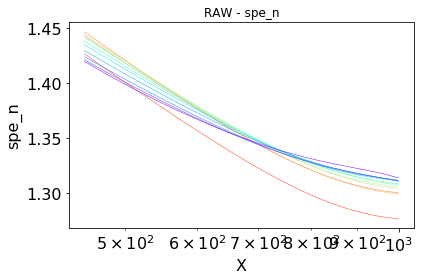

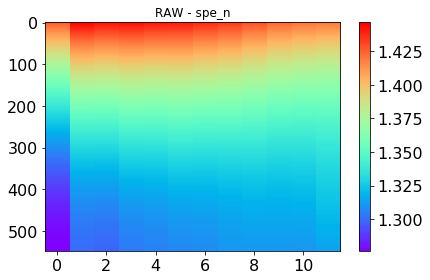

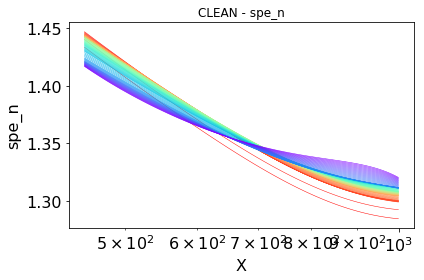

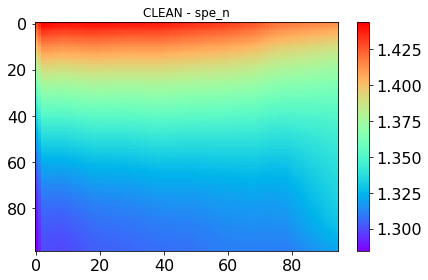

measurement = spe_k


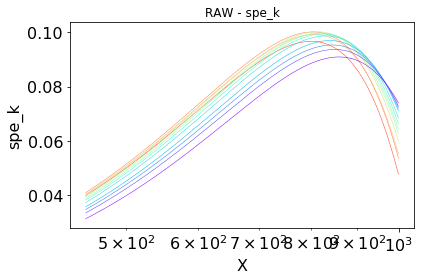

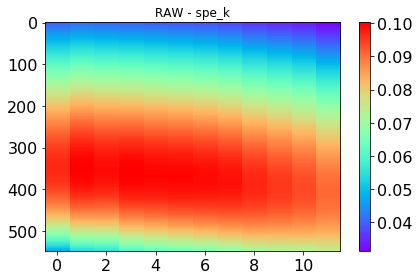

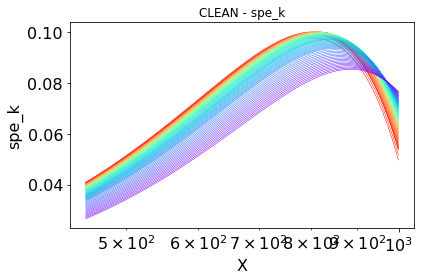

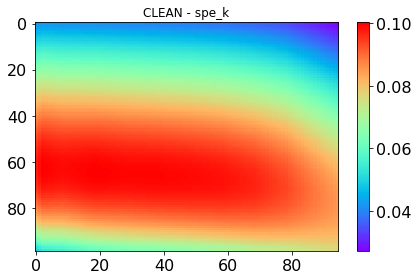

measurement = spe_psi


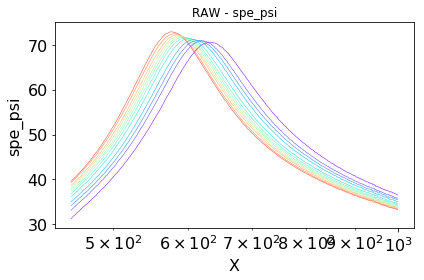

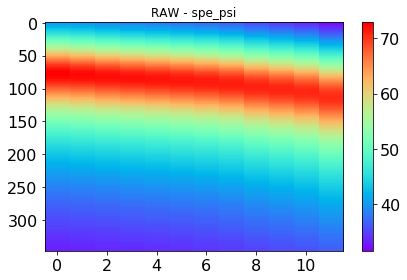

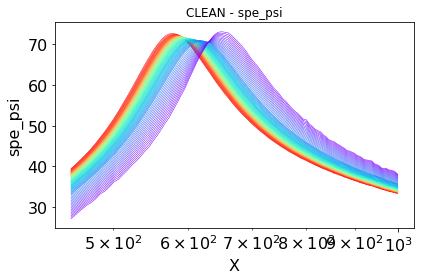

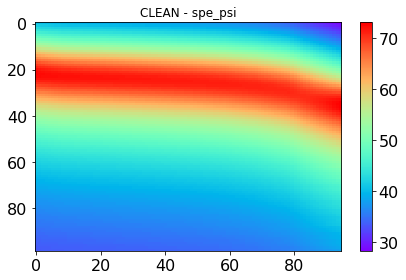

measurement = spe_delta


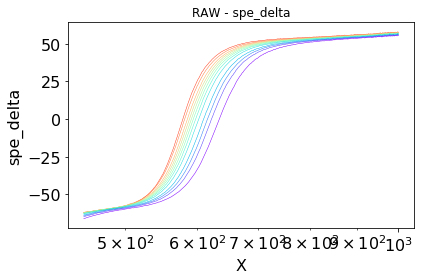

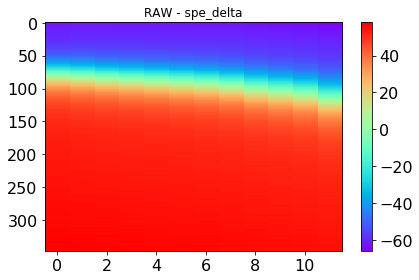

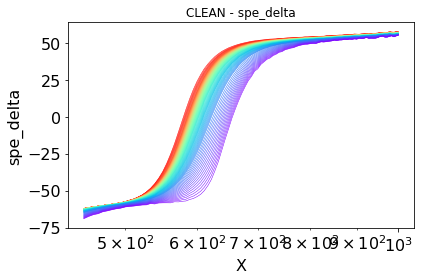

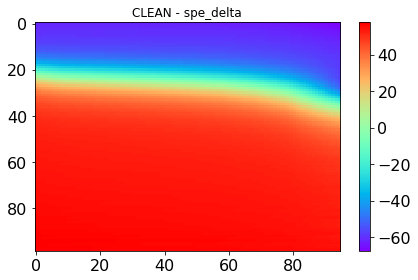

measurement = eis_z


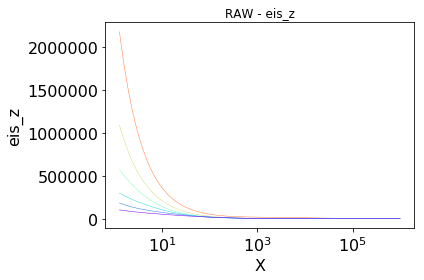

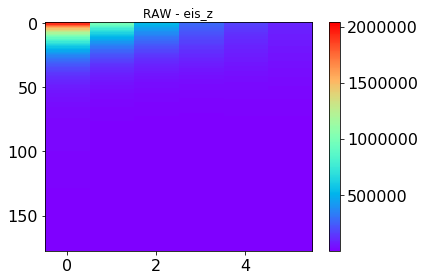

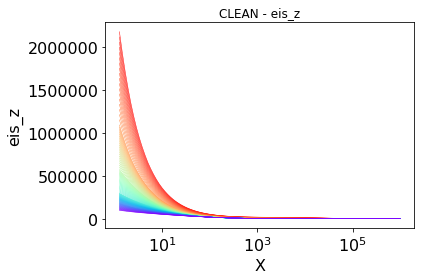

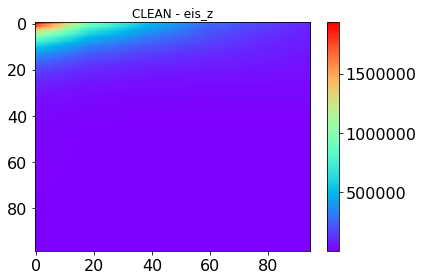

measurement = eis_phase


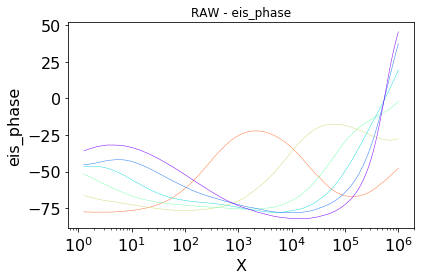

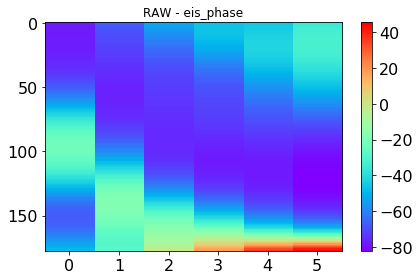

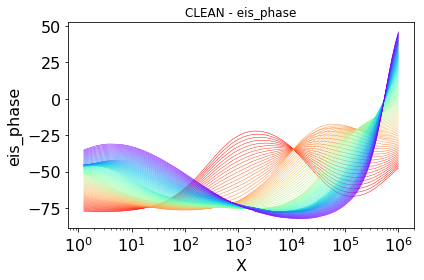

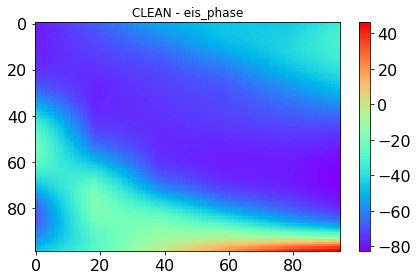

measurement = eis_rez


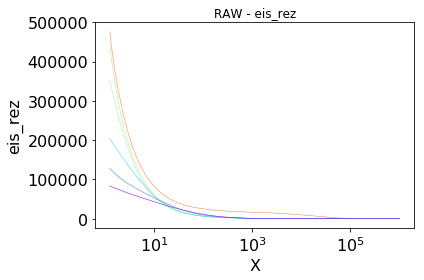

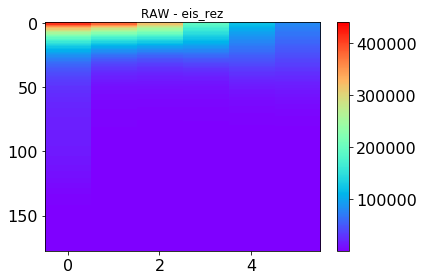

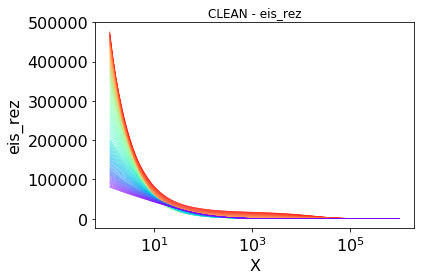

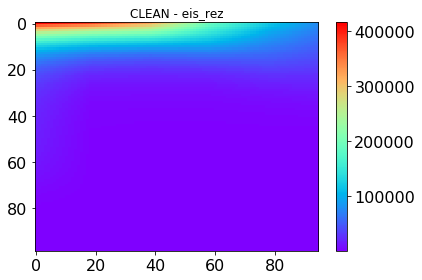

measurement = eis_imz


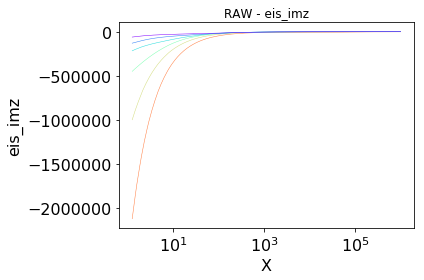

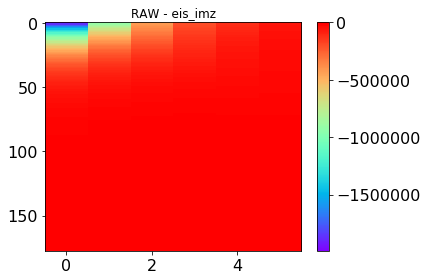

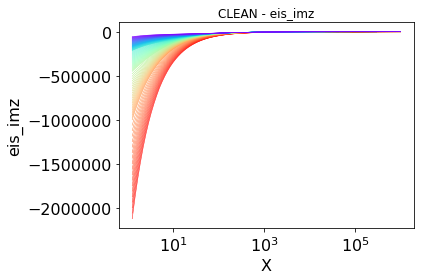

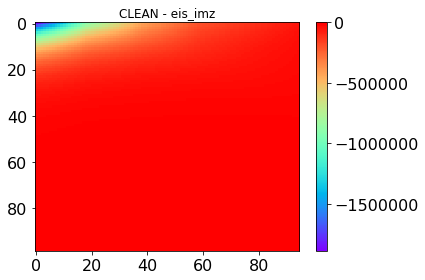

measurement = iv


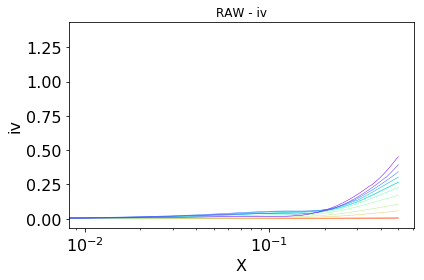

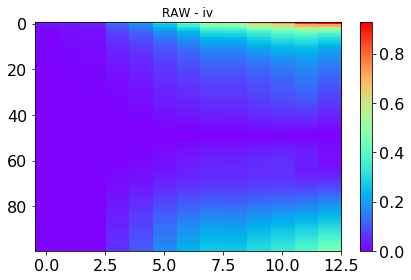

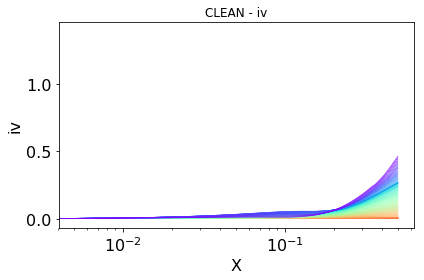

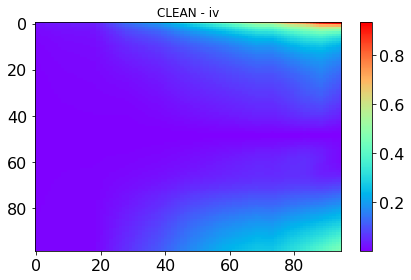

measurement = scalars


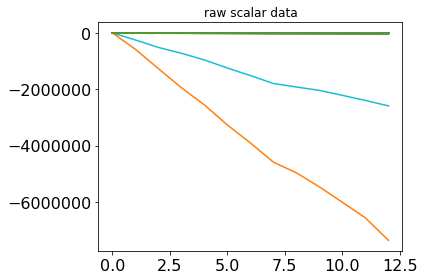

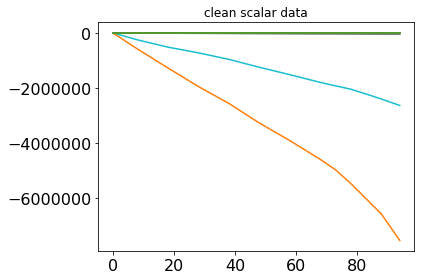

In [142]:
# Use this filepath when importing from a local machine
data_filepath = r'C:\Users\a6q\exp_data\pedotpss_multimode.xlsx'
# Uee this filepath when importing from Google drive
data_filepath = 'gdrive/My Drive/pedotpss_multimode.xlsx'

# create a dictionary to hold all the raw data, so each sheet is put into a
# separate dictionary key
dict_raw = dict(pd.read_excel(data_filepath, None))
# initialize a new dictionary to hold the clean formatted data
dict_clean = {}


new_spec_len = 100
new_rh_list = np.linspace(2, 96, num=95)

# loop over each functional mode in file and stretch the measured data array
for mode in dict_raw:
    print('measurement = %s' % str(mode))

    # set linear or log scale for interpolation
    vec_scale = 'log' if 'eis_' in mode else 'lin'

    # for spectral data (each RH value is associated with vector data)
    if 'scalars' not in mode:
        # stretch array along spectrum axis
        spec_stretched = arr_stretch(dict_raw[mode].values,
                                     new_len=new_spec_len,
                                    vec_scale=vec_scale, k=1)

        # prepare to stretch along RH axis: transponse and add RH as x-values
        spec_stretched_transpose = np.insert(
                spec_stretched[:, 1:].T, 0, list(dict_raw[mode])[1:], axis=1)


        # stretch along RH axis
        rh_stretched = arr_stretch(spec_stretched_transpose,
                                new_len=len(new_rh_list),
                                new_xlims=[new_rh_list[0], new_rh_list[-1]],
                                k=1)

        # add x column and RH headers to stetched array and store as dataframe
        dict_clean[mode] = pd.DataFrame(data=np.insert(
            rh_stretched[:, 1:].T, 0, spec_stretched[:, 0], axis=1),
                columns=np.insert(new_rh_list.astype(str), 0, 'x'))

        # plot new and stretched versions
        for dic0, title0 in zip([dict_raw, dict_clean], ['RAW', 'CLEAN']):

            # line plots
            for col in range(1, len(list(dic0[mode]))):
                colors = cm.rainbow(
                    np.linspace(0, 1, len(list(dic0[mode]))))[::-1]
                if 'eis_' in mode:
                    plt.semilogx(dic0[mode].iloc[:, 0],
                            dic0[mode].iloc[:, col], color=colors[col], lw=0.5)
                else:
                    plt.semilogx(dic0[mode].iloc[:, 0],
                            dic0[mode].iloc[:, col], color=colors[col], lw=0.5)
                    
                plot_setup(labels=['X', str(mode)])
            plt.title(title0+' - '+str(mode))
            plt.show()

            # heatmap plots
            plt.imshow(dic0[mode].iloc[1:, 1:], aspect='auto', cmap='rainbow')
            plt.colorbar()
            plt.title(title0+' - '+str(mode))
            plt.show()

    # for non-spectral data (each RH value is associated with non-vector data)
    if 'scalars' in mode:
        spec_stretched = arr_stretch(dict_raw[mode].values,
                                     new_len=len(new_rh_list),
                                     new_xlims=[new_rh_list[0],
                                                new_rh_list[-1]],
                                    vec_scale=vec_scale, k=1)
        
        dict_clean[mode] = pd.DataFrame(data=spec_stretched,
                columns=list(dict_raw[mode]))

        plt.plot(dict_raw[mode])
        plt.title('raw scalar data')
        plt.show()
        plt.plot(dict_clean[mode])
        plt.title('clean scalar data')
        plt.show()

In [143]:
# dispay the shape of the clean data
print('new RH list: %s' %new_rh_list)
num_of_samples = 0
for key in dict_clean:
    print('%s = %s %s' %(key, np.shape(dict_clean[key]), type(dict_clean[key])))
    num_of_samples += np.prod(np.shape(dict_clean[key]))
print('total samples: %i' %num_of_samples)

## save clean data dictionary to file
# store data (serialize)
from google.colab import files
with open('pp_multimode.pkl', 'wb') as h:
    pickle.dump(dict_clean, h, protocol=pickle.HIGHEST_PROTOCOL)
files.download('pp_multimode.pkl')

new RH list: [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55.
 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73.
 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89. 90. 91.
 92. 93. 94. 95. 96.]
spe_n = (100, 96) <class 'pandas.core.frame.DataFrame'>
spe_k = (100, 96) <class 'pandas.core.frame.DataFrame'>
spe_psi = (100, 96) <class 'pandas.core.frame.DataFrame'>
spe_delta = (100, 96) <class 'pandas.core.frame.DataFrame'>
eis_z = (100, 96) <class 'pandas.core.frame.DataFrame'>
eis_phase = (100, 96) <class 'pandas.core.frame.DataFrame'>
eis_rez = (100, 96) <class 'pandas.core.frame.DataFrame'>
eis_imz = (100, 96) <class 'pandas.core.frame.DataFrame'>
iv = (100, 96) <class 'pandas.core.frame.DataFrame'>
scalars = (95, 23) <class 'pandas.core.frame.DataFrame'>
total samples: 88585


# Building models in Keras / Tensorflow

In [0]:
from numpy.random import seed
from tensorflow import set_random_seed
import keras
from keras import optimizers
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer

 Fix the numpy and tensorflow random number generators so we can reproduce
 the model results each time we run the code. This is not esential but it
 helps for judging the model performance when a model parameter is changed.

In [0]:
seed(1)
set_random_seed(2)

### Designate which data which will be used for training and testing the model.

In [0]:
input_mat = np.random.random((10000, 16))
input_mat[:, 0] = np.arange(len(input_mat))**(1/2)
input_mat[:, 1] = -np.arange(len(input_mat))*0.1
input_mat[:, 2] = -np.arange(len(input_mat))
input_mat[:, 3] = np.arange(len(input_mat))**(3)/1000
input_mat[:, 4] = np.arange(len(input_mat))-100

input_mat[:, -1] = np.arange(len(input_mat))
tar_col = len(input_mat[0]) - 1

In [0]:
# sizes of train and test sets
percent_to_train = 70
train_size = int(len(input_mat) * percent_to_train/100) 
test_size= len(input_mat) - train_size

# normalization and splitting into train/test sets
scaler = MinMaxScaler(feature_range=(0, 1))
# prefix "_s" = scaled 
training_mat_s = scaler.fit_transform(input_mat)
train_inp_s =  training_mat_s[:train_size, :-1]
train_tar_s = training_mat_s[:train_size, tar_col].reshape((train_size, 1))
test_inp_s = training_mat_s[train_size:, :-1]
test_tar_s = training_mat_s[train_size:, tar_col]


Train on 5950 samples, validate on 1050 samples
Epoch 1/50
5950/5950 [==============================] - 1s 225us/step - loss: 0.0819 - val_loss: 0.1155
Epoch 2/50
5950/5950 [==============================] - 0s 4us/step - loss: 0.0283 - val_loss: 0.1116
Epoch 3/50
5950/5950 [==============================] - 0s 4us/step - loss: 0.0269 - val_loss: 0.1115
Epoch 4/50
5950/5950 [==============================] - 0s 4us/step - loss: 0.0252 - val_loss: 0.0974
Epoch 5/50
5950/5950 [==============================] - 0s 4us/step - loss: 0.0228 - val_loss: 0.0816
Epoch 6/50
5950/5950 [==============================] - 0s 4us/step - loss: 0.0194 - val_loss: 0.0646
Epoch 7/50
5950/5950 [==============================] - 0s 4us/step - loss: 0.0154 - val_loss: 0.0436
Epoch 8/50
5950/5950 [==============================] - 0s 4us/step - loss: 0.0114 - val_loss: 0.0257
Epoch 9/50
5950/5950 [==============================] - 0s 4us/step - loss: 0.0079 - val_loss: 0.0154
Epoch 10/50
5950/5950 [=========

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


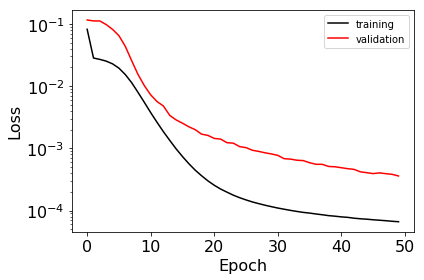

In [338]:
class GetWeights(Callback):
    # Keras callback which collects values of weights and biases at each epoch
    def __init__(self):
        super(GetWeights, self).__init__()
        self.weight_dict = {}
    def on_epoch_end(self, epoch, logs=None):
        # this function runs at the end of each epoch
        # loop over each layer and get weights and biases
        for layer_i in range(len(self.model.layers)):
            w = self.model.layers[layer_i].get_weights()[0]
            b = self.model.layers[layer_i].get_weights()[1]
            # save all weights and biases inside a dictionary
            if epoch == 0:
                # create array to hold weights and biases
                self.weight_dict['w_'+str(layer_i+1)] = w
                self.weight_dict['b_'+str(layer_i+1)] = b
            else:
                # append new weights to previously-created weights array
                self.weight_dict['w_'+str(layer_i+1)] = np.dstack(
                    (self.weight_dict['w_'+str(layer_i+1)], w))
                # append new weights to previously-created weights array
                self.weight_dict['b_'+str(layer_i+1)] = np.dstack(
                    (self.weight_dict['b_'+str(layer_i+1)], b))        
gw = GetWeights()
   

#%% create the model
train_start_time = timer()
model = Sequential([#Dropout(.05, input_shape=(train_inp_s.shape[1:])),
                    Dense(8, activation='relu', input_shape=(train_inp_s.shape[1:])),
                    #Dropout(0.1, seed=1),
                    #Dense(4, activation='relu'),
                    Dense(4, activation='relu'),
                    #Dense(6, activation='relu'),
                    #Dropout(.2, seed=1),
                  Dense(1)])

sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)

#%% train model

epochs = 50

history= model.fit(train_inp_s, train_tar_s,
                   validation_split=0.15,
                   epochs=epochs,
                   batch_size=500,
                   verbose=1,
                   callbacks=[gw])
print('training time = %.1f sec (%.2f min)' %(timer()-train_start_time,
                                 (timer()-train_start_time)/60))

#%% plot loss during training if running locally

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.semilogy(loss, c='k') # Plot training loss
plt.semilogy(val_loss, c='r')
plot_setup(['Epoch', 'Loss'])
plt.legend(['training', 'validation'])
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


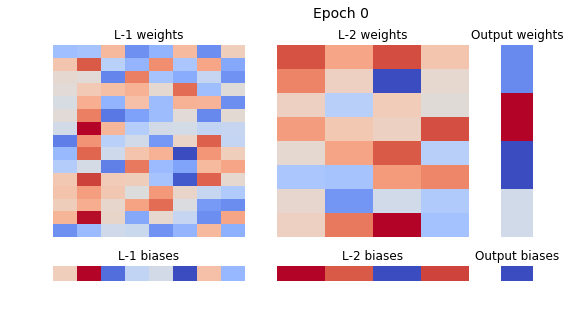

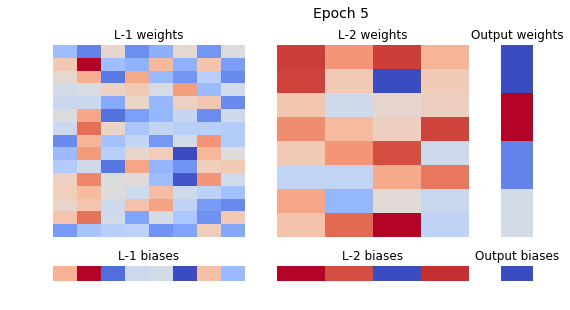

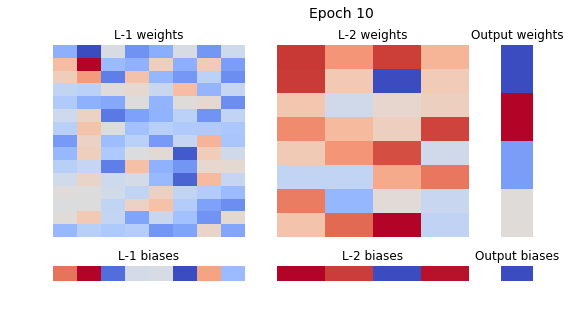

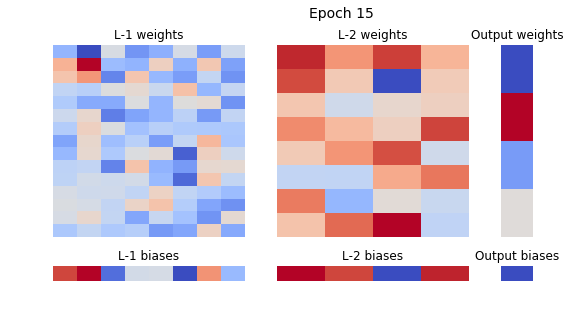

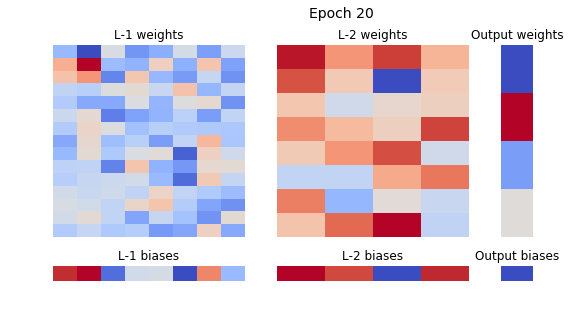

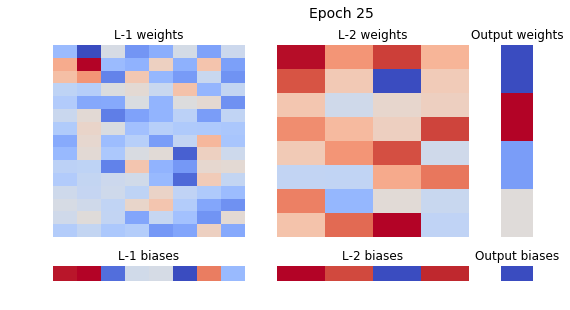

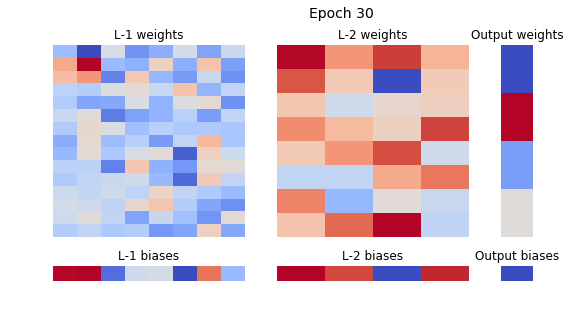

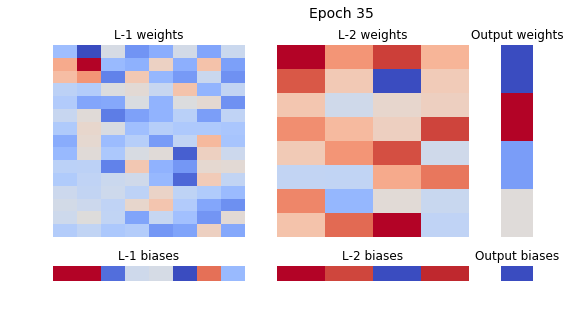

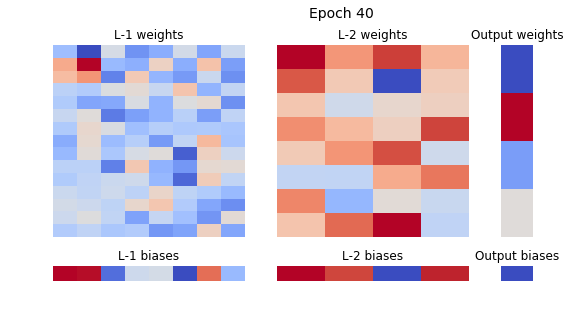

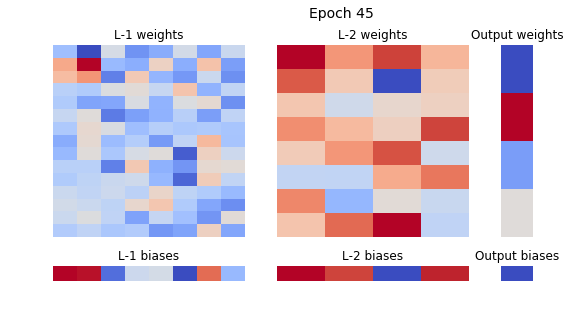

In [346]:
import matplotlib.gridspec as gridspec
from matplotlib import cm

wd = gw.weight_dict

# loop over each epoch in the training session
for epoch in range(0, 50, 5):#len(list(wd.values())[0][0,0,:]), 30):

    # layout the figure based on the number of layers
    fig = plt.figure(figsize=(10, 4))
    gs_stretch = 6
    gs = gridspec.GridSpec(6, int(len(wd)/2)*gs_stretch, figure=fig)
    gs.update(left=0.1, right=0.9, top=0.85, bottom=0.03, wspace=0.01, hspace=2)

    # loop over each array of weights and biases
    for key_i, key in enumerate(wd):
        # print(str(key) + ' shape: %s' %str(np.shape(gw.weight_dict[key])))
        # check if key is a weights key
        if 'w' in key:
            # row and column to place plot
            row, col = gs.get_geometry()[0]-1, gs_stretch*int(key_i/2)+int(key_i/2)
            # normal layer
            if key != list(wd.keys())[-2]:
                plt.subplot(gs[:row, col:col+gs_stretch]).axis('off')
                plt.gca().set_title('L-'+str(1+int(key_i/2))+' weights')
            # output layer
            else:
                plt.subplot(gs[:row, col]).axis('off')
                plt.gca().set_title('Output weights')
        # check if key is a biases key
        if 'b' in key:
            # normal layer
            if key != list(wd.keys())[-1]:
                plt.subplot(gs[row, col:col+gs_stretch]).axis('off') 
                plt.gca().set_title('L-'+str(1+int(key_i/2))+' biases') 
            # output layer
            else:
                plt.subplot(gs[row, col]).axis('off')
                plt.gca().set_title('Output biases')

        plt.imshow(wd[key][:,:,epoch],
                aspect='auto',
                cmap=plt.get_cmap('coolwarm'),
                interpolation='nearest')

    fig.suptitle('Epoch '+str(epoch), fontsize=14)
    plt.axis('off')
    plt.show()

    fig_filename = 'epoch_'+str(epoch).zfill(5)+'.png'
    #fig.savefig(fig_filename, dpi=50)
    #files.download(fig_filename)


In [340]:
str(epoch).zfill(4)+'.png'

'0045.png'

In [341]:
'''
import matplotlib.gridspec as gridspec
from matplotlib import cm

wd = gw.weight_dict

# layout the figure based on the number of layers
fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(5, int(len(wd)-1), figure=fig)
gs.update(left=0.1, right=0.9, top=0.85, bottom=0.03, wspace=0.1, hspace=0.8)


epoch = 8

#for epoch in 

# loop over each array of weights and biases
for key_i, key in enumerate(wd):
    print(str(key) + ' shape: %s' %str(np.shape(gw.weight_dict[key])))

    # check if key is a weights key
    if 'w' in key:

        # check for last layer so we can label is as output layer
        if key != list(wd.keys())[-2]:
            plt.subplot(gs[:4, int(key_i/2)+1]).axis('off')
            plt.gca().set_title('L-'+str(1+int(key_i/2))+' weights')
        else:
            plt.gca().set_title('Output weights')
        
    # check if key is a biases key
    if 'b' in key:
        plt.subplot(gs[4, int(key_i/2)+1]).axis('off')    
        # check for last layer so we can label is as output layer
        if key != list(wd.keys())[-1]:
            plt.gca().set_title('L-'+str(1+int(key_i/2))+' biases') 
        else:
            plt.gca().set_title('Output biases')

    plt.imshow(wd[key][:,:,epoch],
               aspect='auto',
               cmap=plt.get_cmap('seismic'),
               interpolation='nearest')

fig.suptitle('Epoch '+str(epoch), fontsize=14)
plt.axis('off')
plt.show()
'''

"\nimport matplotlib.gridspec as gridspec\nfrom matplotlib import cm\n\nwd = gw.weight_dict\n\n# layout the figure based on the number of layers\nfig = plt.figure(figsize=(10, 4))\ngs = gridspec.GridSpec(5, int(len(wd)-1), figure=fig)\ngs.update(left=0.1, right=0.9, top=0.85, bottom=0.03, wspace=0.1, hspace=0.8)\n\n\nepoch = 8\n\n#for epoch in \n\n# loop over each array of weights and biases\nfor key_i, key in enumerate(wd):\n    print(str(key) + ' shape: %s' %str(np.shape(gw.weight_dict[key])))\n\n    # check if key is a weights key\n    if 'w' in key:\n\n        # check for last layer so we can label is as output layer\n        if key != list(wd.keys())[-2]:\n            plt.subplot(gs[:4, int(key_i/2)+1]).axis('off')\n            plt.gca().set_title('L-'+str(1+int(key_i/2))+' weights')\n        else:\n            plt.gca().set_title('Output weights')\n        \n    # check if key is a biases key\n    if 'b' in key:\n        plt.subplot(gs[4, int(key_i/2)+1]).axis('off')    \n       

In [342]:
gs.get_geometry()[0]

6

In [0]:


def create_video(image_folder, video_name, fps=8, reverse=False):
    #create video out of images saved in a folder
    import cv2
    import os
    
    images = [img for img in os.listdir(image_folder) if img.endswith('.jpg')]
    if reverse: images = images[::-1]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, -1, fps, (width,height))
    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))
    cv2.destroyAllWindows()
    video.release()


make_video = False
if make_video:
    create_video('exp_data\\save_CV_plots_2019-01-28_pss\\',
                 'C:\\Users\\a6q\\Desktop\\PSS_CV_fast.avi', fps=16)





In [344]:
'''

plt.plot(weight_min_max[:,0])
plt.title('weight min')
plt.show()

plt.plot(weight_min_max[:,1])
plt.title('weight max')
plt.show()
'''

"\n\nplt.plot(weight_min_max[:,0])\nplt.title('weight min')\nplt.show()\n\nplt.plot(weight_min_max[:,1])\nplt.title('weight max')\nplt.show()\n"

In [345]:
'''
#%% make predictions
trained_model_s = model.predict(train_inp_s), 
future_predictions_s = model.predict(test_inp_s)

#%% get sparse matrices which have same shape as scaled 
# training/testing data so we can unscale ANN results
# so we can unscale using the same scaler as before
trained_model_mat_s = np.zeros((train_size,len(input_mat[0])))
future_predictions_mat_s = np.zeros((test_size,len(input_mat[0])))
test_tar_mat_s = np.copy(future_predictions_mat_s)

# insert our data into its corresponding column of each sparse matrix
trained_model_mat_s[:,tar_col] = np.ndarray.flatten(np.array(trained_model_s))
future_predictions_mat_s[:,tar_col] = np.ndarray.flatten(future_predictions_s)


#%%# unscale our data
trained_model = scaler.inverse_transform(trained_model_mat_s)[:,tar_col]
future_pred = scaler.inverse_transform(future_predictions_mat_s)[:,tar_col]
train_tar = sig[:train_size]

plt.plot(time[train_size:],future_pred, c='r', label='prediction')
plt.scatter(time, sig, c='k', s=3, alpha=0.1, label='measured')
plt.plot(time[:train_size], trained_model, c='b', alpha=0.5, label='model')
plt.xlabel('Time (min)', fontsize=label_size)
plt.ylabel('Amplitude', fontsize=label_size)
plt.legend()
plt.show()

#%% make error calculations
tot_model = np.append(trained_model, future_pred)
error_raw = np.subtract(sig, tot_model)
percent_error = 100*np.abs(error_raw)/np.max(np.abs(sig))

fig, ax1 = plt.subplots()
ax1.plot(time, pressure, linewidth=0.5, c='b')
ax1.set_xlabel('Time (min)', fontsize=label_size)
ax1.set_ylabel('Pressure', color='b', fontsize=label_size)

ax2 = ax1.twinx()
ax2.plot(time, percent_error, linewidth=0.5, c='r')
ax2.set_ylabel('% error', color='r', fontsize=label_size)
ax2.tick_params('y', colors='r')
plt.show()

print('avg. percent error = %.2f' %(np.mean(percent_error)))
'''

"\n#%% make predictions\ntrained_model_s = model.predict(train_inp_s), \nfuture_predictions_s = model.predict(test_inp_s)\n\n#%% get sparse matrices which have same shape as scaled \n# training/testing data so we can unscale ANN results\n# so we can unscale using the same scaler as before\ntrained_model_mat_s = np.zeros((train_size,len(input_mat[0])))\nfuture_predictions_mat_s = np.zeros((test_size,len(input_mat[0])))\ntest_tar_mat_s = np.copy(future_predictions_mat_s)\n\n# insert our data into its corresponding column of each sparse matrix\ntrained_model_mat_s[:,tar_col] = np.ndarray.flatten(np.array(trained_model_s))\nfuture_predictions_mat_s[:,tar_col] = np.ndarray.flatten(future_predictions_s)\n\n\n#%%# unscale our data\ntrained_model = scaler.inverse_transform(trained_model_mat_s)[:,tar_col]\nfuture_pred = scaler.inverse_transform(future_predictions_mat_s)[:,tar_col]\ntrain_tar = sig[:train_size]\n\nplt.plot(time[train_size:],future_pred, c='r', label='prediction')\nplt.scatter(ti